In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import numpy as np
import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "icml2024"  # set to your entity and project 

In [3]:
# create dict mapping sweep name to sweep id
sweep_id_dict = {
    "gen_bayes_dsprites_sweep_0": "e52tk53s",
    "gen_bayes_mnist_sweep_000_25k_0": "ry03ghvb",
    "gen_bayes_mnist_sweep_000_37k5_0": "z81qc61i",
    "gen_bayes_mnist_sweep_000_50k_0": "bkg0c2to",
}

In [4]:
summary_list, config_list, name_list, tags, ids, states, sweeps = [], [], [], [], [], [],  []

for sweep, sweep_id in sweep_id_dict.items():
    runs = api.sweep(entity + "/" + project + "/" + sweep_id).runs

    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        tags.append(run.tags)

        ids.append(run.id)

        states.append(run.state)

        sweeps.append(sweep)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states,
    "sweep": sweeps,
    })

runs_df

,summary,config,name,tags,id,state,sweep
0,"{'train/loss': -7.653676509857178, 'mae_loss_m...","{'lr': 0.0013191602199859893, 'seed': 0, 'mode...",absurd-sweep-64,[],rjuyn8s9,finished,gen_bayes_dsprites_sweep_0
1,"{'_step': 60000, '_timestamp': 1702668230.0210...","{'lr': 0.000793143468640839, 'seed': 0, 'model...",dashing-sweep-63,[],ggfmxtxc,finished,gen_bayes_dsprites_sweep_0
2,"{'_runtime': 752.4160044193268, 'gen_plots_4':...","{'lr': 0.0007251114471102164, 'seed': 0, 'mode...",sparkling-sweep-62,[],2c07m9px,finished,gen_bayes_dsprites_sweep_0
3,"{'_wandb': {'runtime': 1143}, 'gen_plots_1': {...","{'lr': 0.000531383132524569, 'seed': 0, 'model...",ethereal-sweep-61,[],e5bpkrtf,finished,gen_bayes_dsprites_sweep_0
4,"{'_runtime': 957.1220428943634, 'gen_plots_0':...","{'lr': 0.0008592830289135964, 'seed': 0, 'mode...",ruby-sweep-60,[],qyhmcexb,finished,gen_bayes_dsprites_sweep_0
...,...,...,...,...,...,...,...
251,"{'inf_plots_1': {'_type': 'image-file', 'width...","{'lr': 0.004172150430401814, 'seed': 0, 'angle...",fiery-sweep-5,[],q2j5yo7y,finished,gen_bayes_mnist_sweep_000_50k_0
252,"{'_wandb': {'runtime': 870}, '_runtime': 737.8...","{'lr': 0.0005379183921309325, 'seed': 0, 'angl...",glad-sweep-4,[],ew2ngmiw,finished,gen_bayes_mnist_sweep_000_50k_0
253,"{'_runtime': 258.5234339237213, 'valid/loss': ...","{'lr': 0.0002661280961955489, 'seed': 0, 'angl...",dry-sweep-3,[],zlwrzpuk,finished,gen_bayes_mnist_sweep_000_50k_0
254,"{'valid/mae': 0.7909809947013855, 'inf_plots_2...","{'lr': 0.003879836385559382, 'seed': 0, 'angle...",usual-sweep-2,[],i75v2yt1,finished,gen_bayes_mnist_sweep_000_50k_0


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'sweep', 'summary.train/loss',
       'summary.mae_loss_mult', 'summary.valid/loss',
       'summary.train/log_p_η_x_hat', 'summary.valid/mae',
       ...
       'config.aug_dsprites.ellipse_distribution.x_position',
       'config.aug_dsprites.ellipse_distribution.y_position',
       'config.aug_dsprites.ellipse_distribution.orientation',
       'config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob',
       'config.angle', 'config.num_trn', 'config.num_val', 'config.shuffle',
       'config.shuffle_buffer_size', 'config.repeat_after_batching'],
      dtype='object', length=167)

In [6]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] != 'failed']

# take only runs with certain tags
# tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
# df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

# replace nans in config.num_trn and config.angle with -1
df_filtered['config.num_trn'] = df_filtered['config.num_trn'].fillna(-1)
df_filtered['config.angle'] = df_filtered['config.angle'].fillna(0)

df_filtered

,name,tags,id,state,sweep,summary.train/loss,summary.mae_loss_mult,summary.valid/loss,summary.train/log_p_η_x_hat,summary.valid/mae,summary._step,summary._runtime,summary.train/mae,summary.valid/log_p_η_x_hat,summary.grad_norm,summary._timestamp,summary.lr_gen,summary.gen_training_metrics.height,summary.gen_training_metrics.sha256,summary.gen_training_metrics.path,summary.gen_training_metrics.size,summary.gen_training_metrics._type,summary.gen_training_metrics.width,summary.gen_training_metrics.format,summary.gen_plots_1._type,summary.gen_plots_1.width,summary.gen_plots_1.format,summary.gen_plots_1.height,summary.gen_plots_1.sha256,summary.gen_plots_1.path,summary.gen_plots_1.size,summary.gen_plots_2.size,summary.gen_plots_2._type,summary.gen_plots_2.width,summary.gen_plots_2.format,summary.gen_plots_2.height,summary.gen_plots_2.sha256,summary.gen_plots_2.path,summary.inf_plots_2.height,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary._wandb.runtime,summary.gen_plots_0._type,summary.gen_plots_0.width,summary.gen_plots_0.format,summary.gen_plots_0.height,summary.gen_plots_0.sha256,summary.gen_plots_0.path,summary.gen_plots_0.size,summary.inf_plots_3.size,summary.inf_plots_3._type,summary.inf_plots_3.width,summary.inf_plots_3.format,summary.inf_plots_3.height,summary.inf_plots_3.sha256,summary.inf_plots_3.path,summary.gen_rep_plots_2.height,summary.gen_rep_plots_2.sha256,summary.gen_rep_plots_2.path,summary.gen_rep_plots_2.size,summary.gen_rep_plots_2._type,summary.gen_rep_plots_2.width,summary.gen_rep_plots_2.format,summary.gen_rep_plots_0.path,summary.gen_rep_plots_0.size,summary.gen_rep_plots_0._type,summary.gen_rep_plots_0.width,summary.gen_rep_plots_0.format,summary.gen_rep_plots_0.height,summary.gen_rep_plots_0.sha256,summary.gen_plots_3.width,summary.gen_plots_3.format,summary.gen_plots_3.height,summary.gen_plots_3.sha256,summary.gen_plots_3.path,summary.gen_plots_3.size,summary.gen_plots_3._type,summary.gen_plots_4._type,summary.gen_plots_4.width,summary.gen_plots_4.format,summary.gen_plots_4.height,summary.gen_plots_4.sha256,summary.gen_plots_4.path,summary.gen_plots_4.size,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_4.size,summary.gen_rep_plots_1.sha256,summary.gen_rep_plots_1.path,summary.gen_rep_plots_1.size,summary.gen_rep_plots_1._type,summary.gen_rep_plots_1.width,summary.gen_rep_plots_1.format,summary.gen_rep_plots_1.height,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_plots_1._type,config.lr,config.seed,config.steps,config.dataset,config.pp_eval,config.pp_train,config.clip_norm,config.eval_freq,config.n_samples,config.val_split,config.batch_size,config.model_name,config.train_split,config.init_lr_mult,config.weight_decay,config.final_lr_mult,config.augment_bounds,config.augment_offset,config.translate_last,config.warmup_steps_pct,config.interpolation_order,config.mae_loss_mult_final,config.mae_loss_mult_initial,config.model.num_bins,config.model.num_flows,config.model.conditioner.hidden_dims,config.model.conditioner.dropout_rate,config.model.hidden_dims,config.model.dropout_rate,config.model.squash_to_bounds,config.aug_dsprites.heart_distribution.scale,config.aug_dsprites.heart_distribution.x_position,config.aug_dsprites.heart_distribution.y_position,config.aug_dsprites.heart_distribution.orientation,config.aug_dsprites.heart_distribution.unnormalised_shape_prob,config.aug_dsprites.square_distribution.scale,config.aug_dsprites.square_distribution.x_position,config.aug_d

In [7]:
df_filtered['config.angle'].unique()

array([0.])

In [8]:
df_filtered['config.steps'].unique()

array([60000, 30000, 15000,  7500])

In [9]:
df_filtered['config.num_trn'].unique()

array([-1.00e+00,  2.50e+04,  3.75e+04,  5.00e+04])

In [10]:
df_filtered['config.dataset'].unique()

array(['aug_dsprites', 'MNIST'], dtype=object)

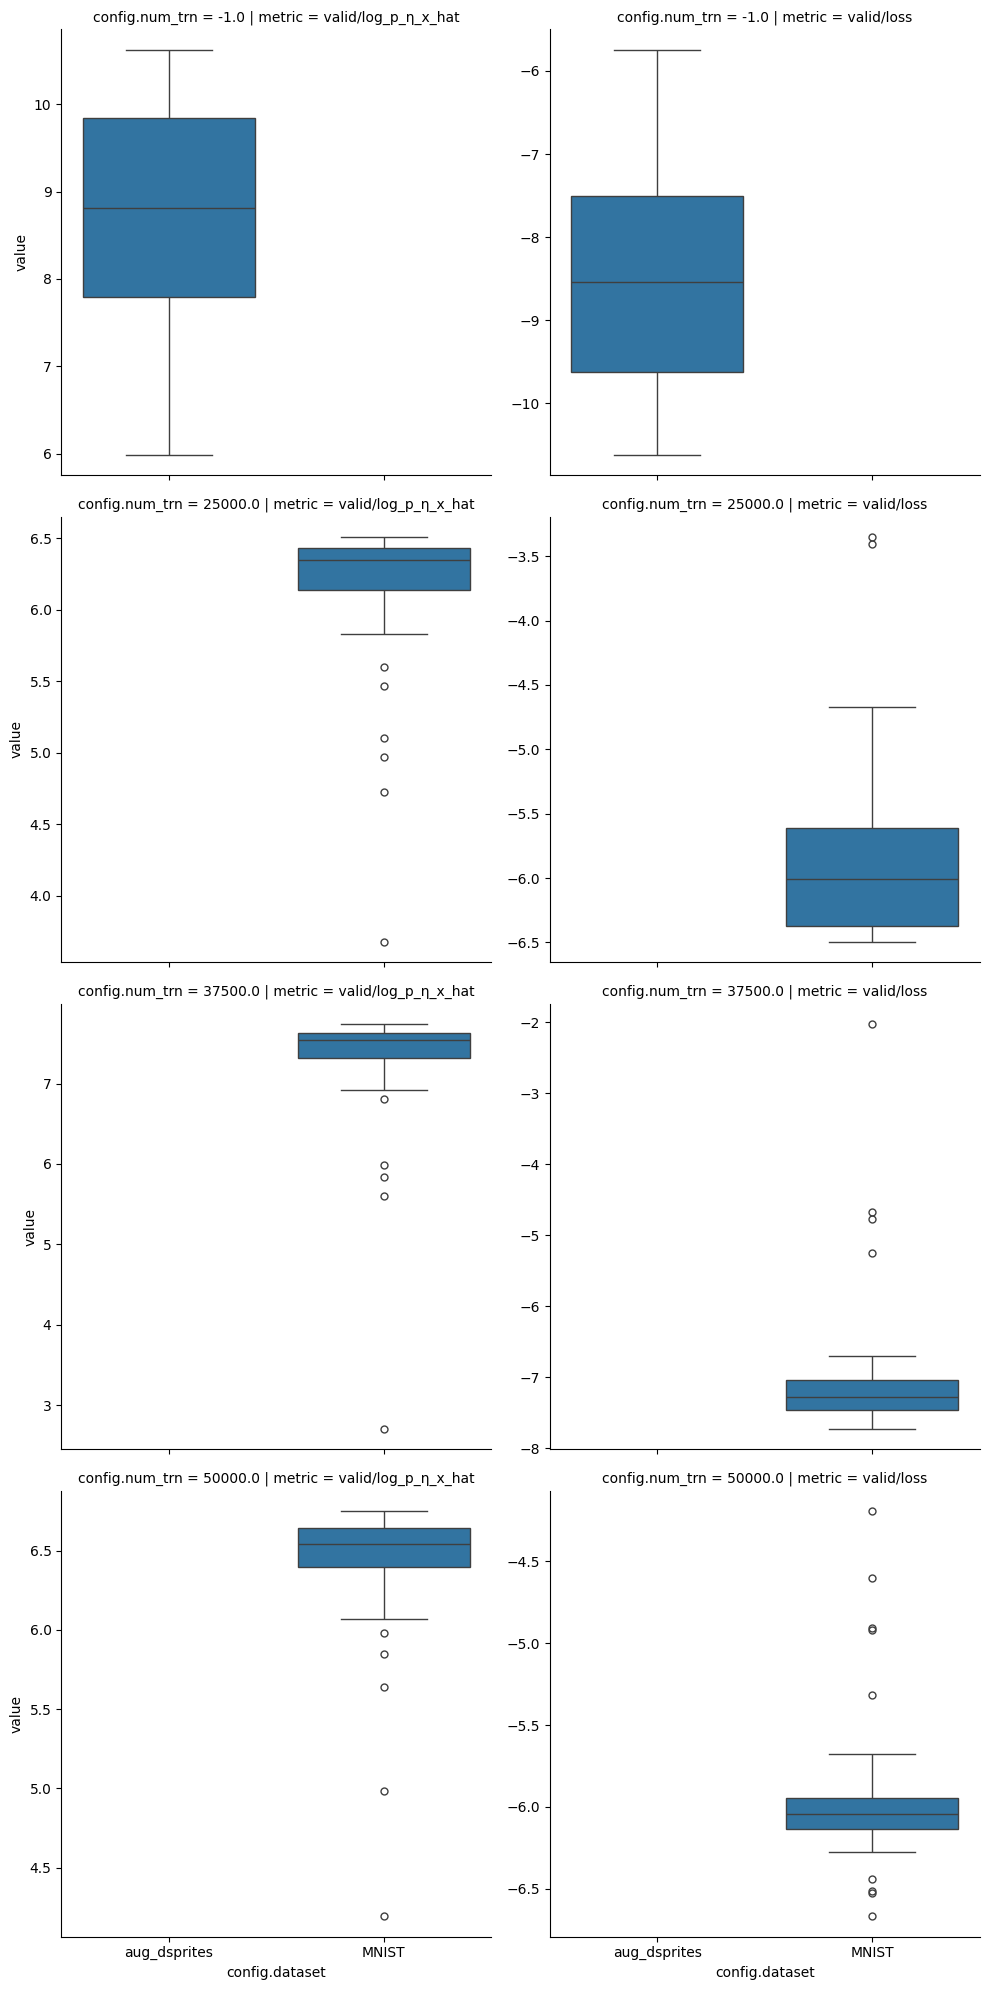

In [11]:
plot_df = df_filtered[[
    'summary.valid/log_p_η_x_hat', 'summary.valid/loss', 'config.angle',  'config.num_trn', 'config.dataset'
]]

# take only some settings
# plot_df = plot_df[
#     plot_df['config.init_lr'].isin([0.0003])
# ]

# pivot the data frame so that each of metrics is a column, and the values are the corresponding values
plot_df = plot_df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'],
    value_vars=['summary.valid/log_p_η_x_hat', 'summary.valid/loss'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


sns.catplot(data=plot_df, x="config.dataset", y="value", col="metric", row='config.num_trn', kind="box", showfliers=True, sharey=False)

In [12]:
hyper_names = ['config.' + x for x in [
    'clip_norm', 'final_lr_mult', 'init_lr_mult', 'lr', 'mae_loss_mult_final', 'mae_loss_mult_initial',
    'model.conditioner.dropout_rate', 'model.conditioner.hidden_dims', 'model.dropout_rate',
    'model.num_bins', 'model.num_flows', 'n_samples', 'steps', 'warmup_steps_pct', 'weight_decay'
]]

In [13]:
df_filtered['config.n_samples'] = df_filtered['config.n_samples'].astype(str)
df_filtered['config.steps'] = df_filtered['config.steps'].astype(str)
df_filtered['config.model.num_flows'] = df_filtered['config.model.num_flows'].astype(str)
df_filtered['config.model.num_bins'] = df_filtered['config.model.num_bins'].astype(str)
df_filtered['config.model.dropout_rate'] = df_filtered['config.model.dropout_rate'].astype(str)
df_filtered['config.model.conditioner.dropout_rate'] = df_filtered['config.model.conditioner.dropout_rate'].astype(str)

In [14]:
# take only the rows where n_samples = 5
# df_filtered = df_filtered[df_filtered['config.n_samples'] == '5']
# and conditioner.dropout_rate = 0.05
# df_filtered = df_filtered[df_filtered['config.model.conditioner.dropout_rate'] == '0.05']
# and conditioner.hidden_dims = 256
# df_filtered = df_filtered[df_filtered['config.model.conditioner.hidden_dims'] == '256']
# and num_bins = 6
# df_filtered = df_filtered[df_filtered['config.model.num_bins'] == '6']

## Analize sweeps

In [15]:
# pivot the data frame so that each of 'summary.valid/x_mse', 'summary.valid/loss', 'summary.valid/label_paired_image_mse'
# is a column, and the values are the corresponding values
df = df_filtered.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'] + hyper_names,
    value_vars=['summary.valid/log_p_η_x_hat', 'summary.valid/loss', 'summary.valid/mae'],
    var_name='metric',
    value_name='value'
)

df

,config.angle,config.num_trn,config.dataset,config.clip_norm,config.final_lr_mult,config.init_lr_mult,config.lr,config.mae_loss_mult_final,config.mae_loss_mult_initial,config.model.conditioner.dropout_rate,config.model.conditioner.hidden_dims,config.model.dropout_rate,config.model.num_bins,config.model.num_flows,config.n_samples,config.steps,config.warmup_steps_pct,config.weight_decay,metric,value
0,0.0,-1.0,aug_dsprites,7.191198,0.016690,0.696859,0.001319,0.004675,0.360157,0.05,256,0.1,8,4,1,60000,0.097842,0.000074,summary.valid/log_p_η_x_hat,8.091173
1,0.0,-1.0,aug_dsprites,1.862061,0.001206,0.749112,0.000793,0.227901,0.113815,0.05,256,0.05,6,4,3,60000,0.052320,0.000038,summary.valid/log_p_η_x_hat,8.690051
2,0.0,-1.0,aug_dsprites,9.013739,0.004971,0.194870,0.000725,0.257906,0.498733,0.05,256,0.05,8,4,3,60000,0.041347,0.000658,summary.valid/log_p_η_x_hat,9.221401
3,0.0,-1.0,aug_dsprites,3.827330,0.276922,0.773432,0.000531,0.255694,0.209266,0.2,"256,256",0.1,8,4,5,60000,0.205163,0.000084,summary.valid/log_p_η_x_hat,10.227556
4,0.0,-1.0,aug_dsprites,6.457212,0.001914,0.655013,0.000859,0.275281,0.190321,0.05,256,0.05,8,4,5,60000,0.128598,0.000074,summary.valid/log_p_η_x_hat,10.279853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.0,50000.0,MNIST,2.547641,0.001655,0.038376,0.004172,0.801261,0.691982,0.05,256,0.05,8,2,3,30000,0.051575,0.000236,summary.valid/mae,0.915442
764,0.0,50000.0,MNIST,1.009613,0.114662,0.213590,0.000538,0.045536,0.928396,0.05,"256,256",0.05,8,4,1,60000,0.060998,0.000063,summary.valid/mae,0.000000
765,0.0,50000.0,MNIST,1.593497,0.695294,0.558167,0.000266,0.918829,0.224470,0.05,256,0.05,8,4,5,15000,0.003080,0.000752,summary.valid/mae,1.011324
766,0.0,50000.0,MNIST,5.204919,0.049671,0.057623,0.003880,0.503964,0.495341,0.1,"256,256",0.2,8,4,5,60000,0.283843,0.000230,summary.valid/mae,0.790981


In [16]:
METRIC = 'summary.valid/log_p_η_x_hat'

In [17]:
hyper_names

['config.clip_norm',
 'config.final_lr_mult',
 'config.init_lr_mult',
 'config.lr',
 'config.mae_loss_mult_final',
 'config.mae_loss_mult_initial',
 'config.model.conditioner.dropout_rate',
 'config.model.conditioner.hidden_dims',
 'config.model.dropout_rate',
 'config.model.num_bins',
 'config.model.num_flows',
 'config.n_samples',
 'config.steps',
 'config.warmup_steps_pct',
 'config.weight_decay']

### clip_norm

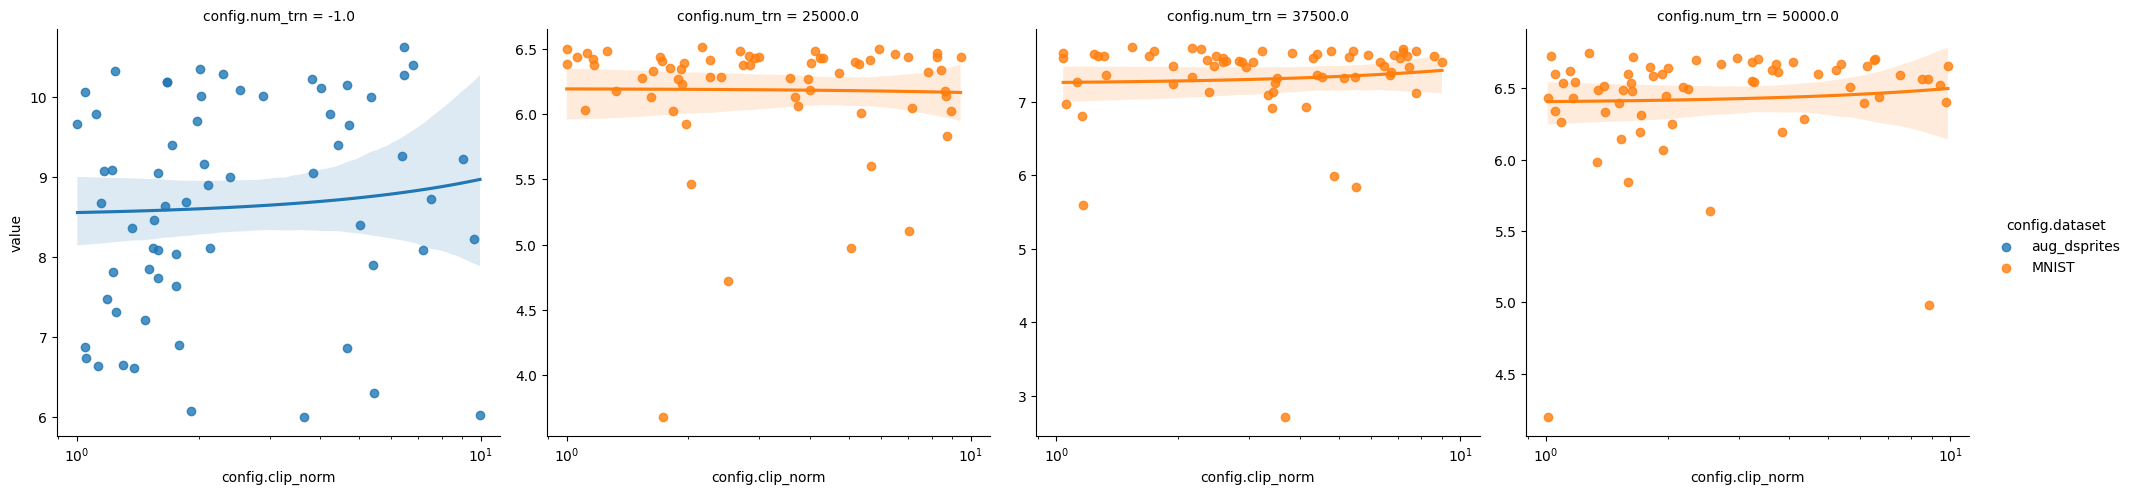

In [18]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

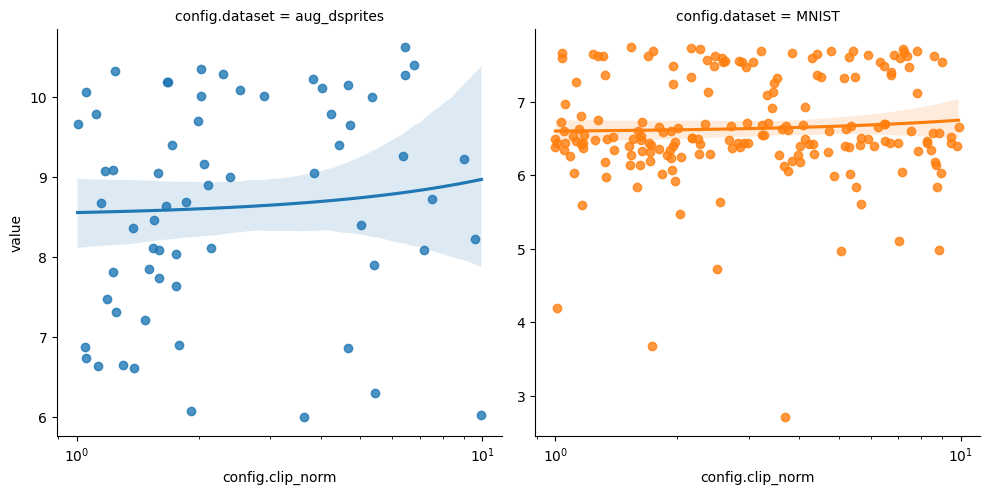

In [19]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### final_lr_mult

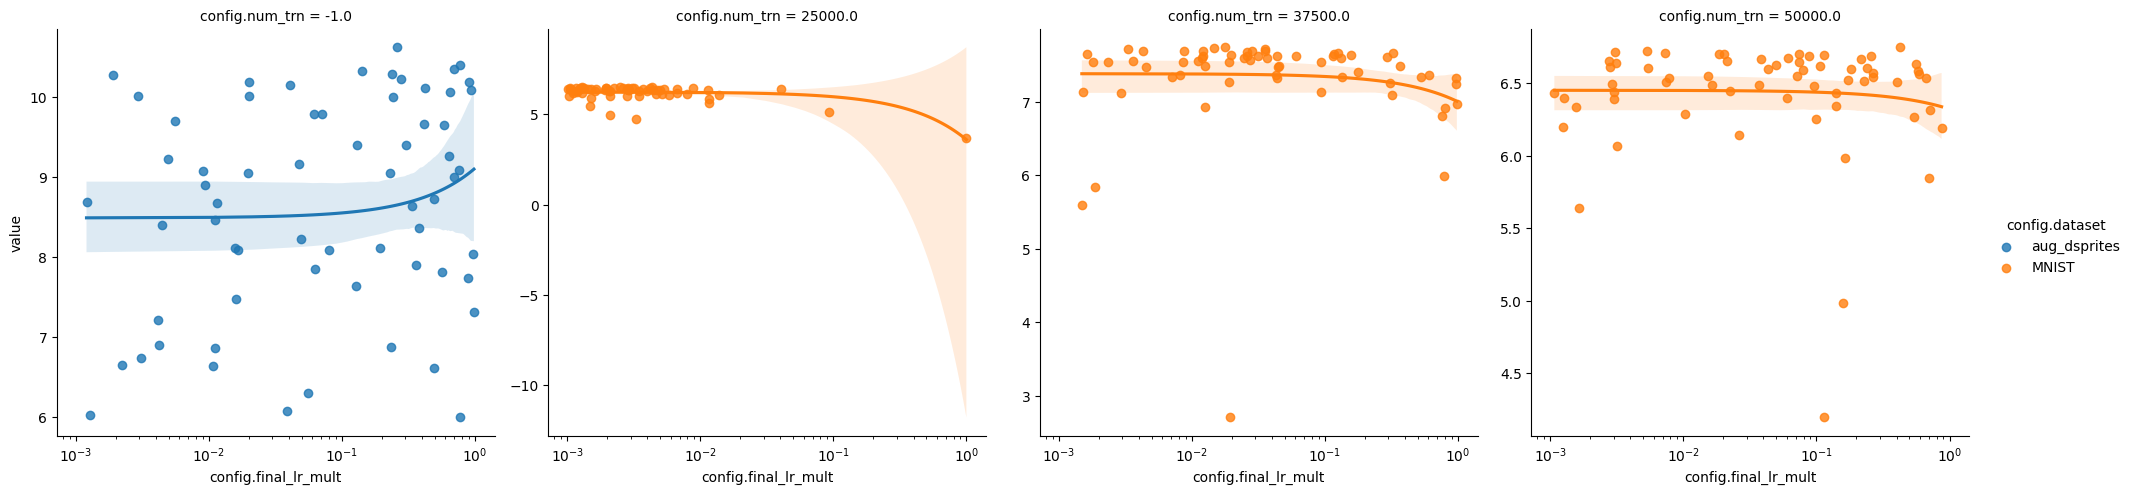

In [20]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

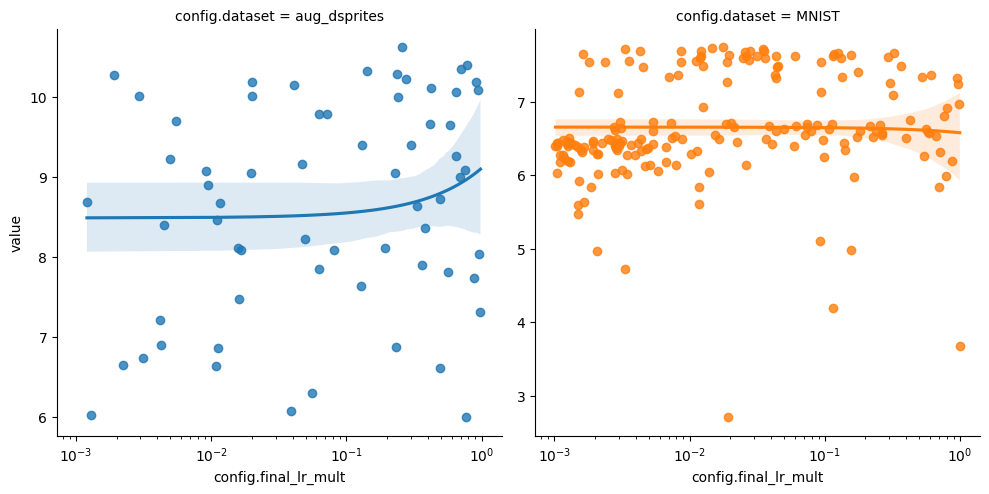

In [21]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### init_lr_mult

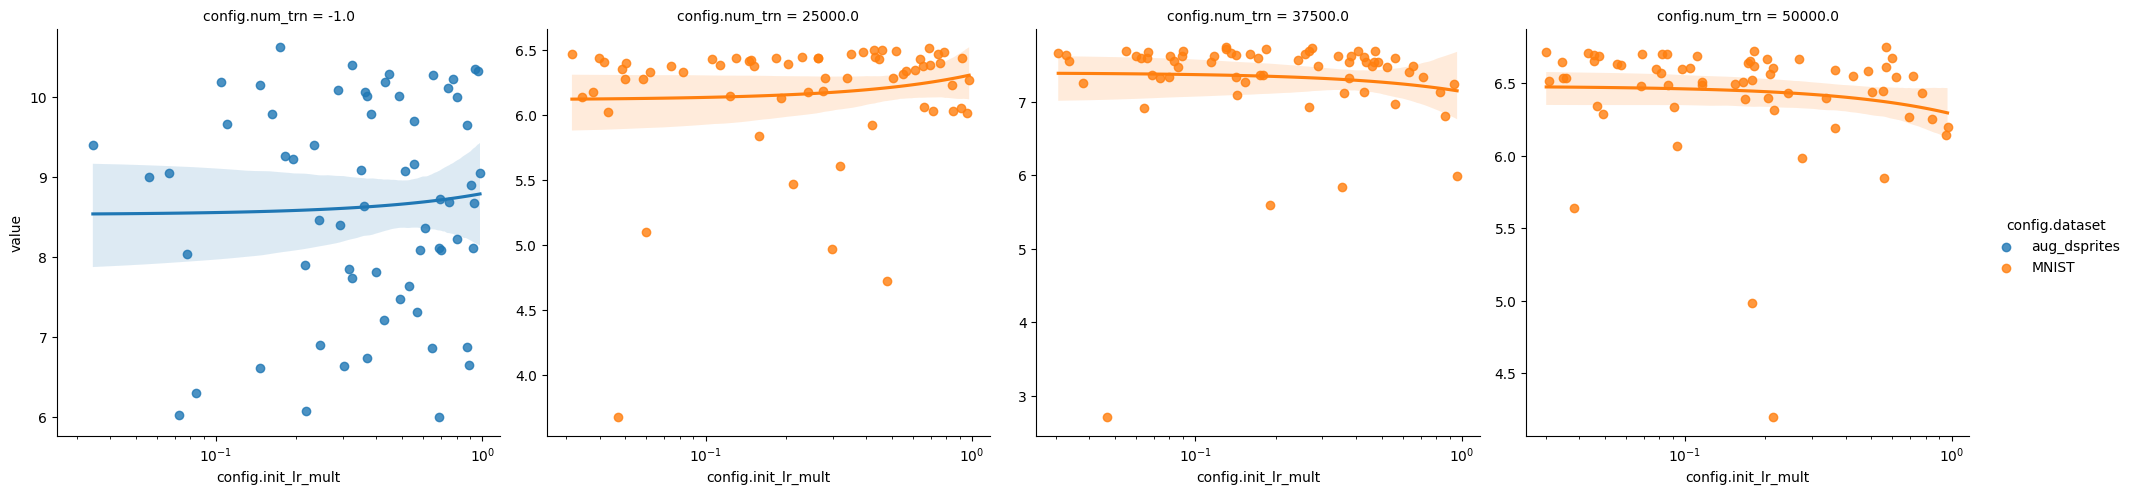

In [22]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

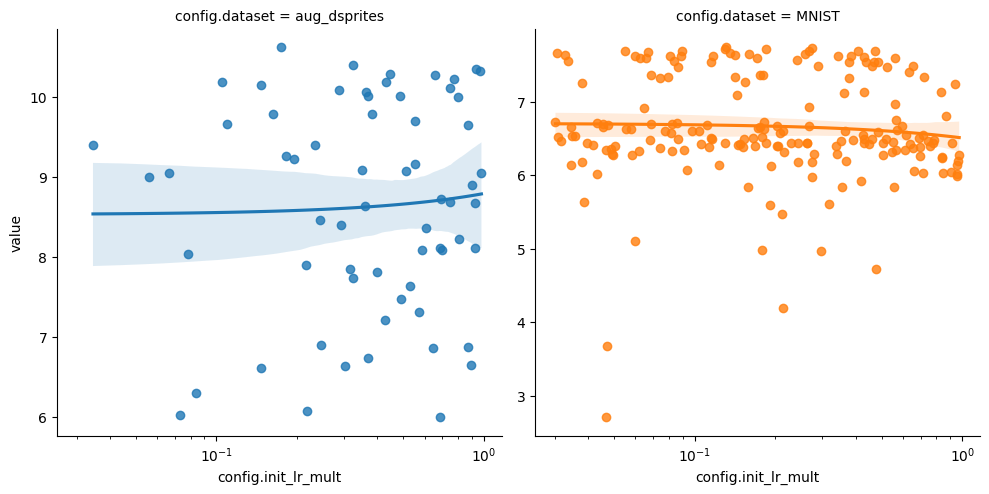

In [23]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### lr

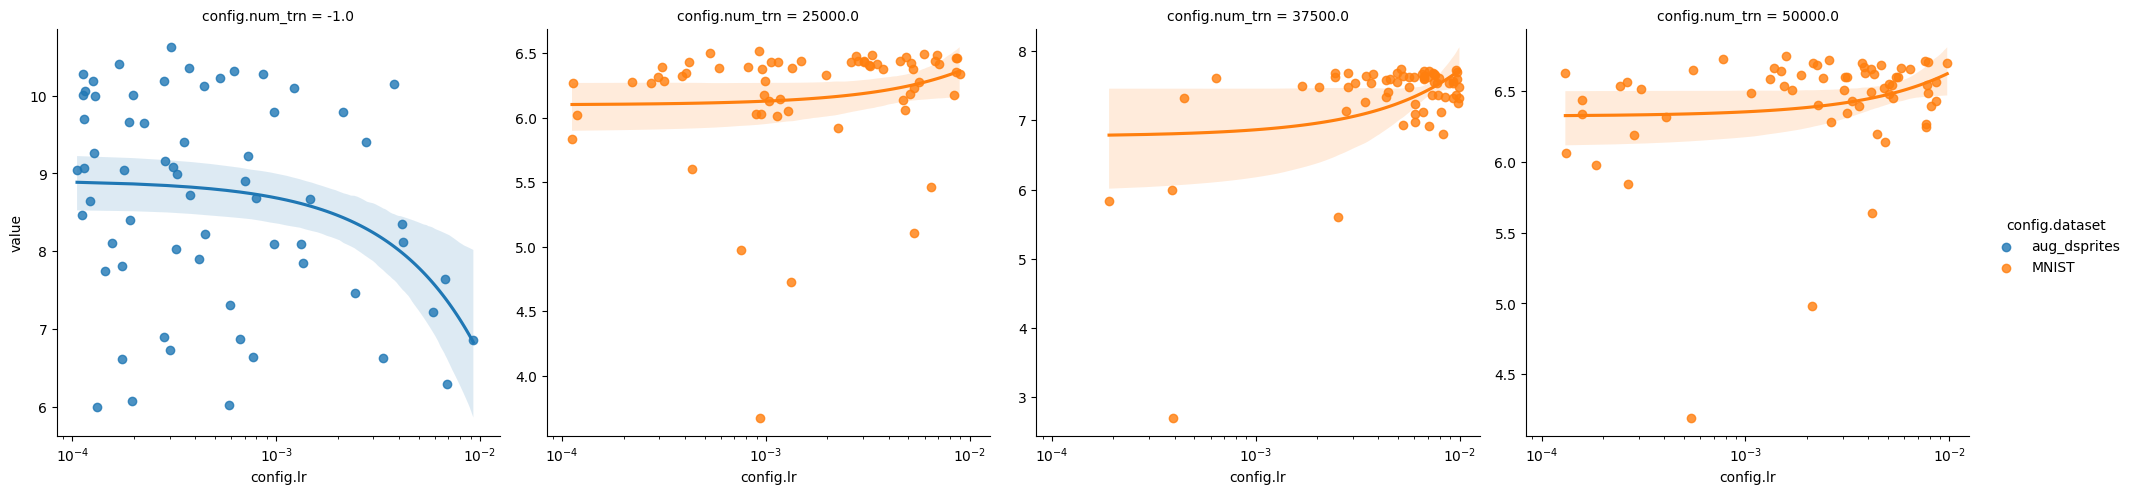

In [24]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

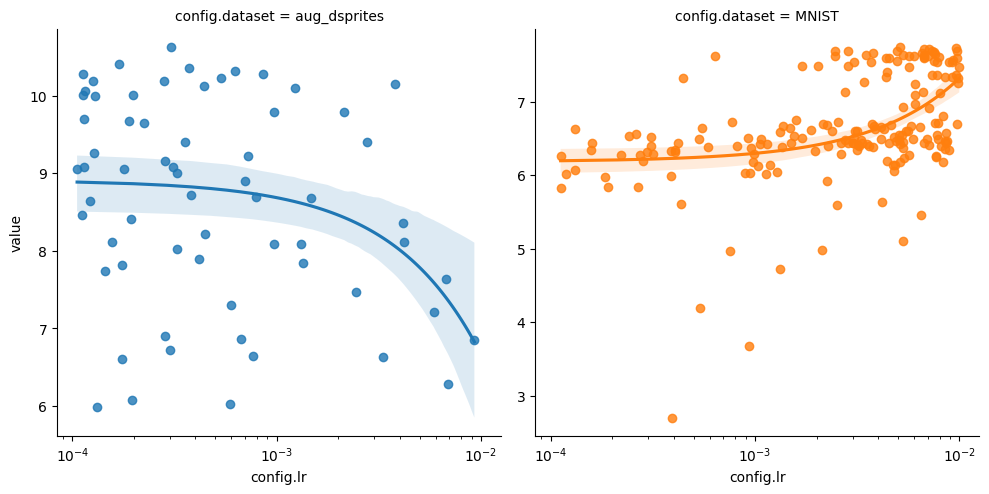

In [25]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

### mae_loss_mult_final

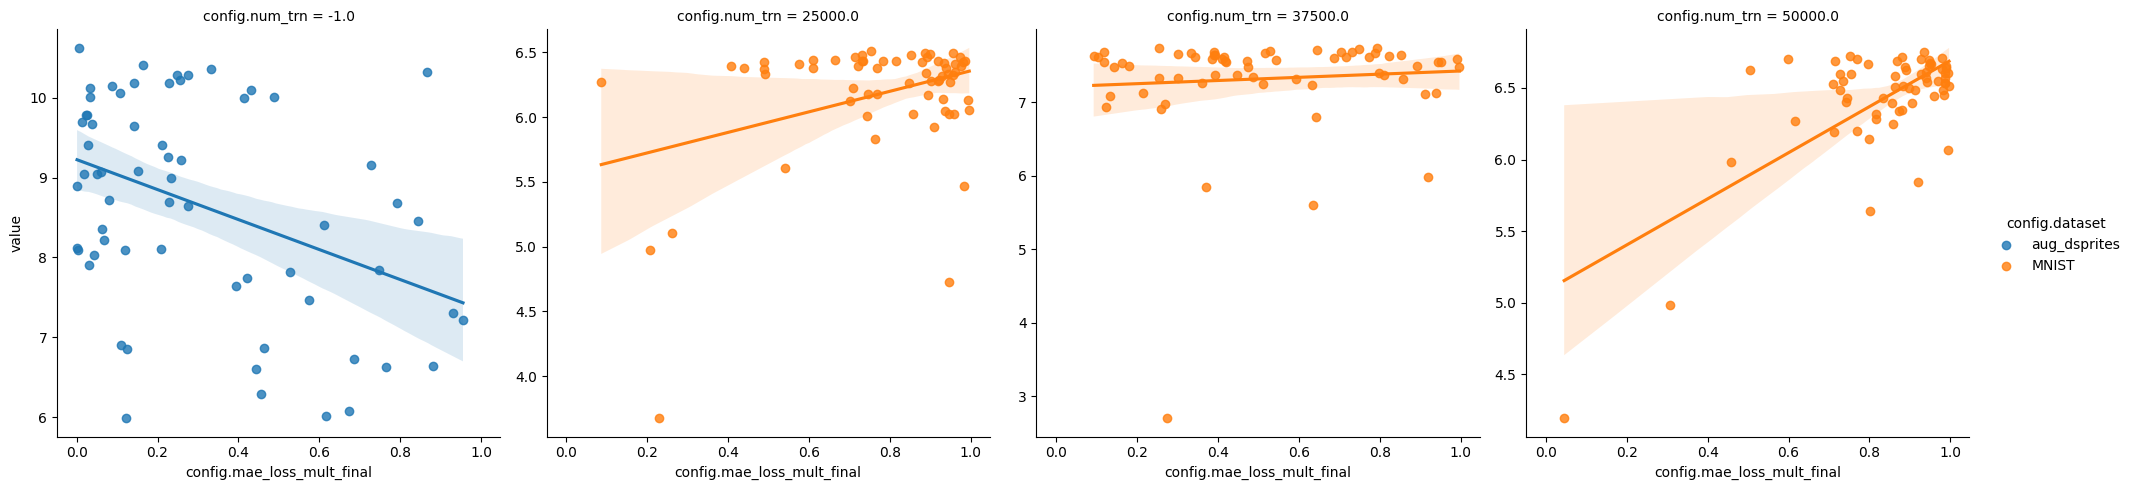

In [26]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_final",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

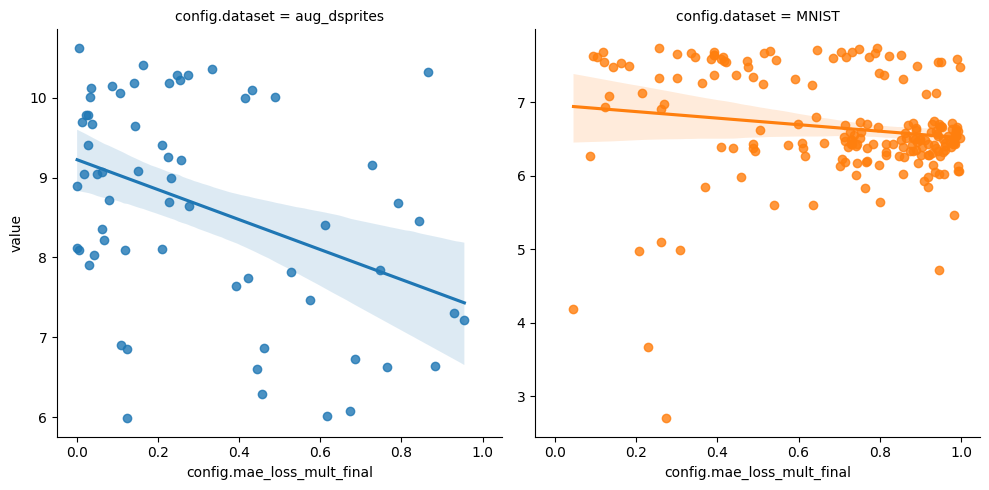

In [27]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_final",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

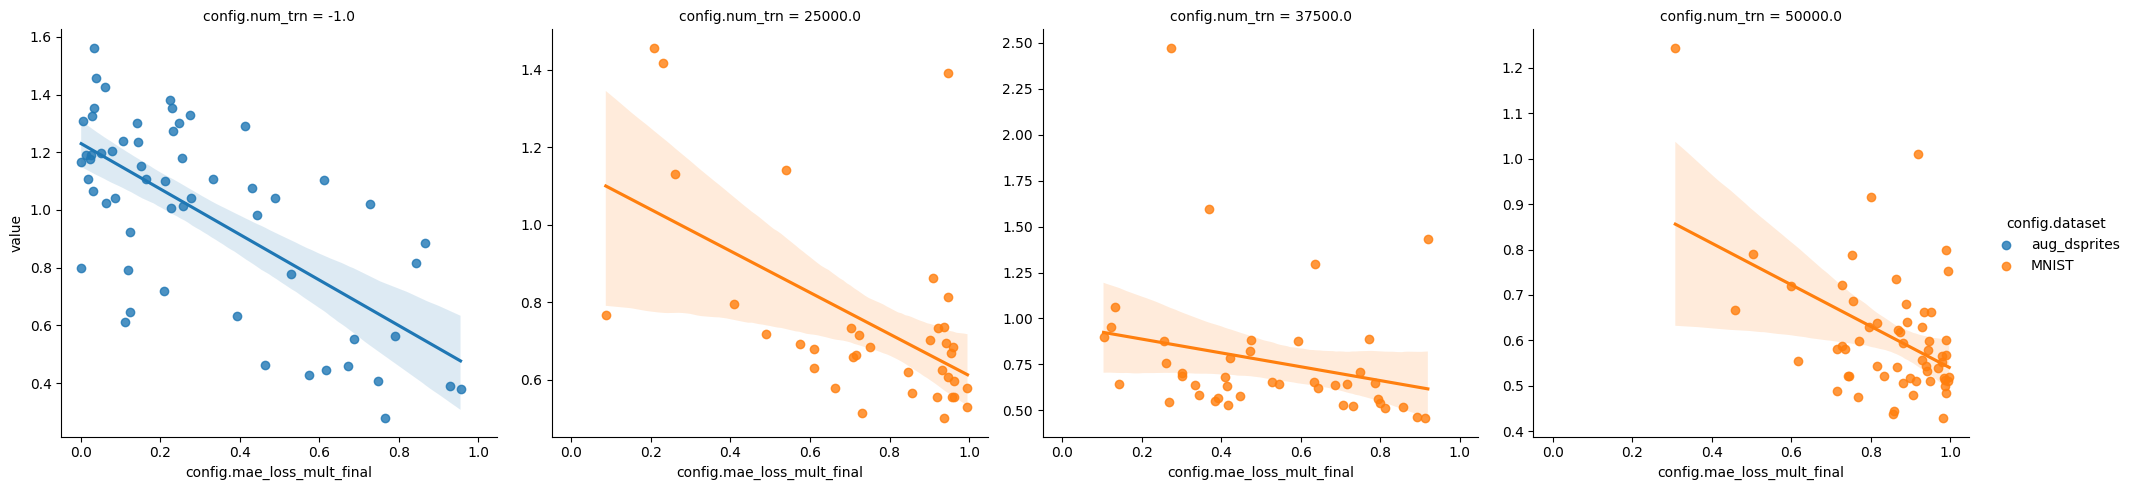

In [28]:
g = sns.lmplot(
    data=df[(df.metric == "summary.valid/mae") & (df.value != 0)],
    x="config.mae_loss_mult_final",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

### mae_loss_mult_initial

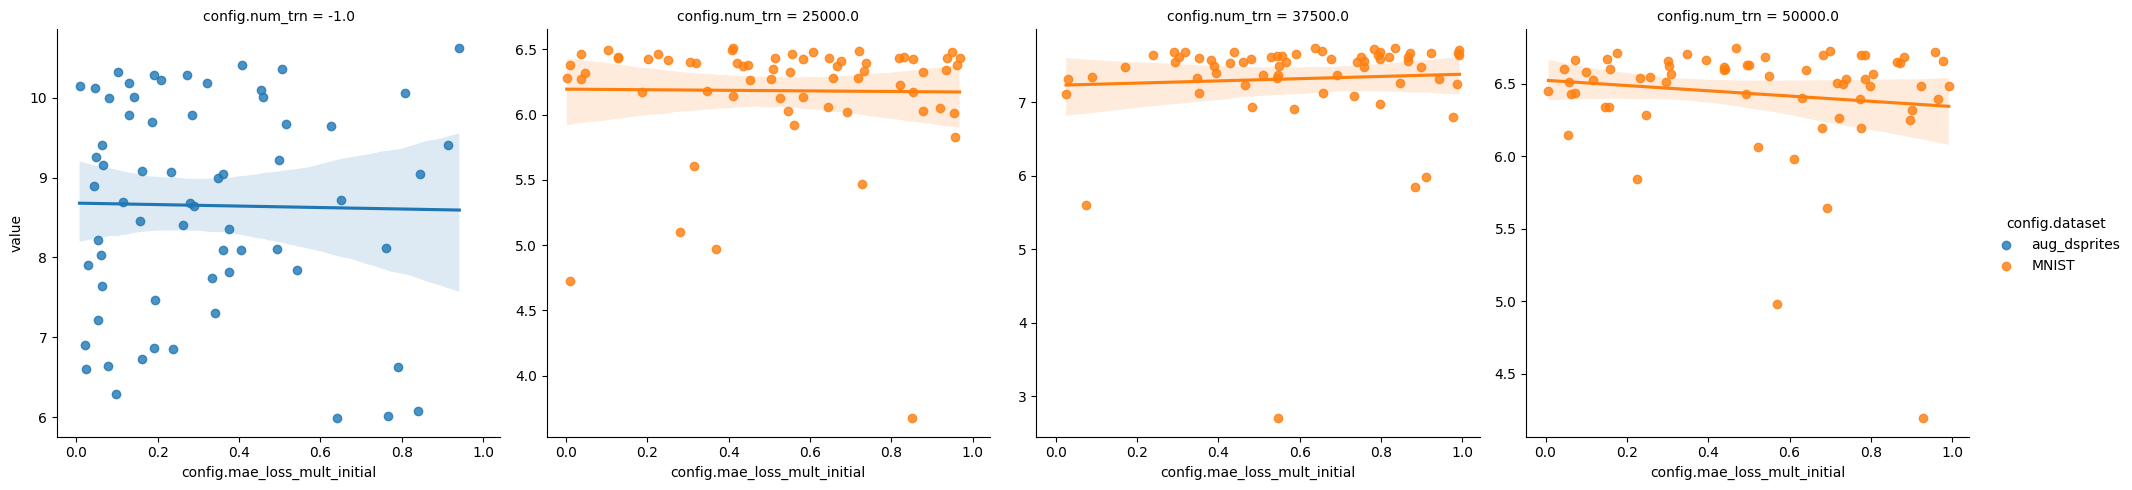

In [29]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_initial",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

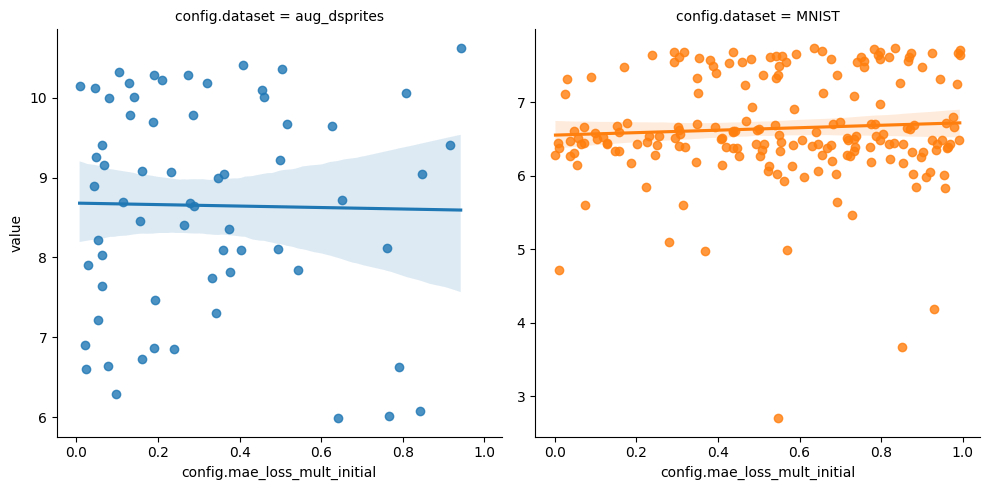

In [30]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.mae_loss_mult_initial",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

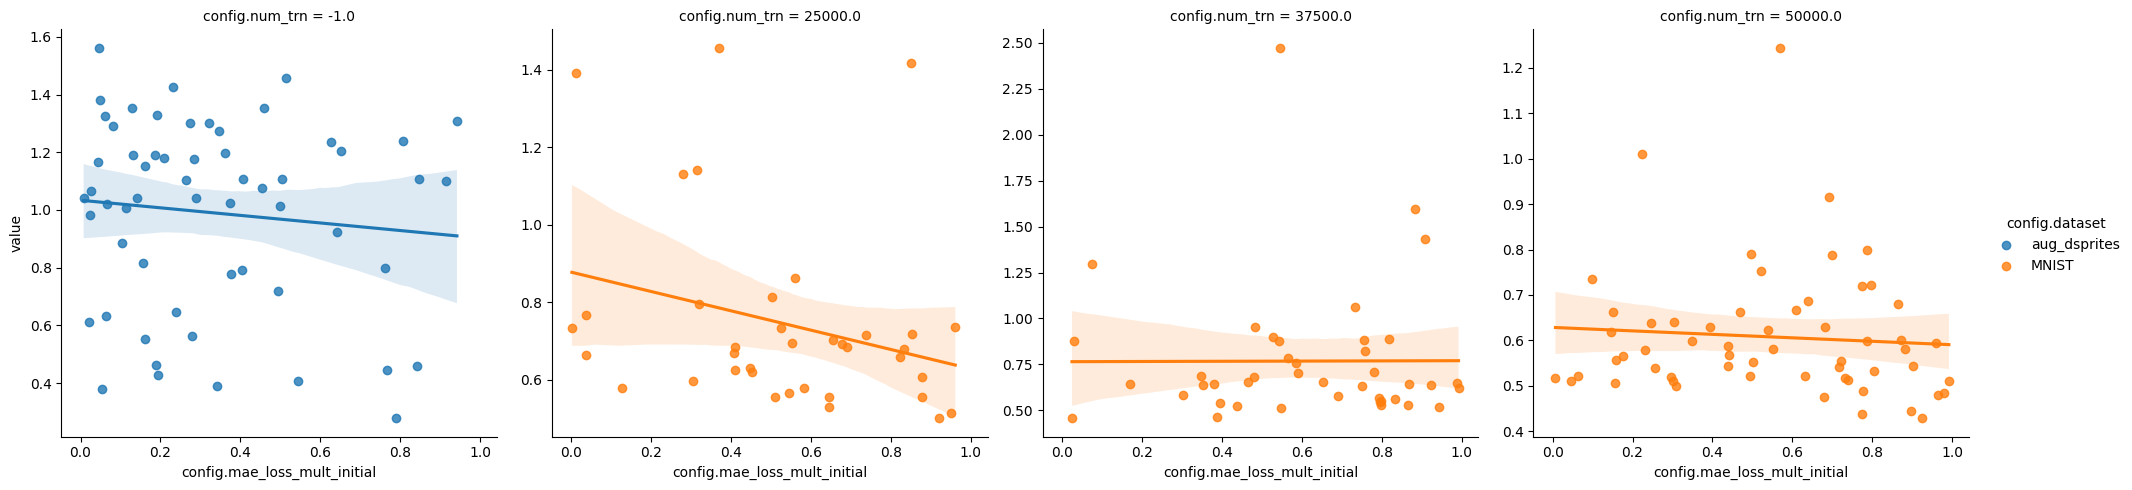

In [31]:
g = sns.lmplot(
    data=df[(df.metric == "summary.valid/mae") & (df.value != 0)],
    x="config.mae_loss_mult_initial",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

/tmp/ipykernel_335875/2634605070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['value_rel'] = df_tmp['value'] / df_tmp.groupby(['config.dataset', 'metric'])['value'].transform('max')


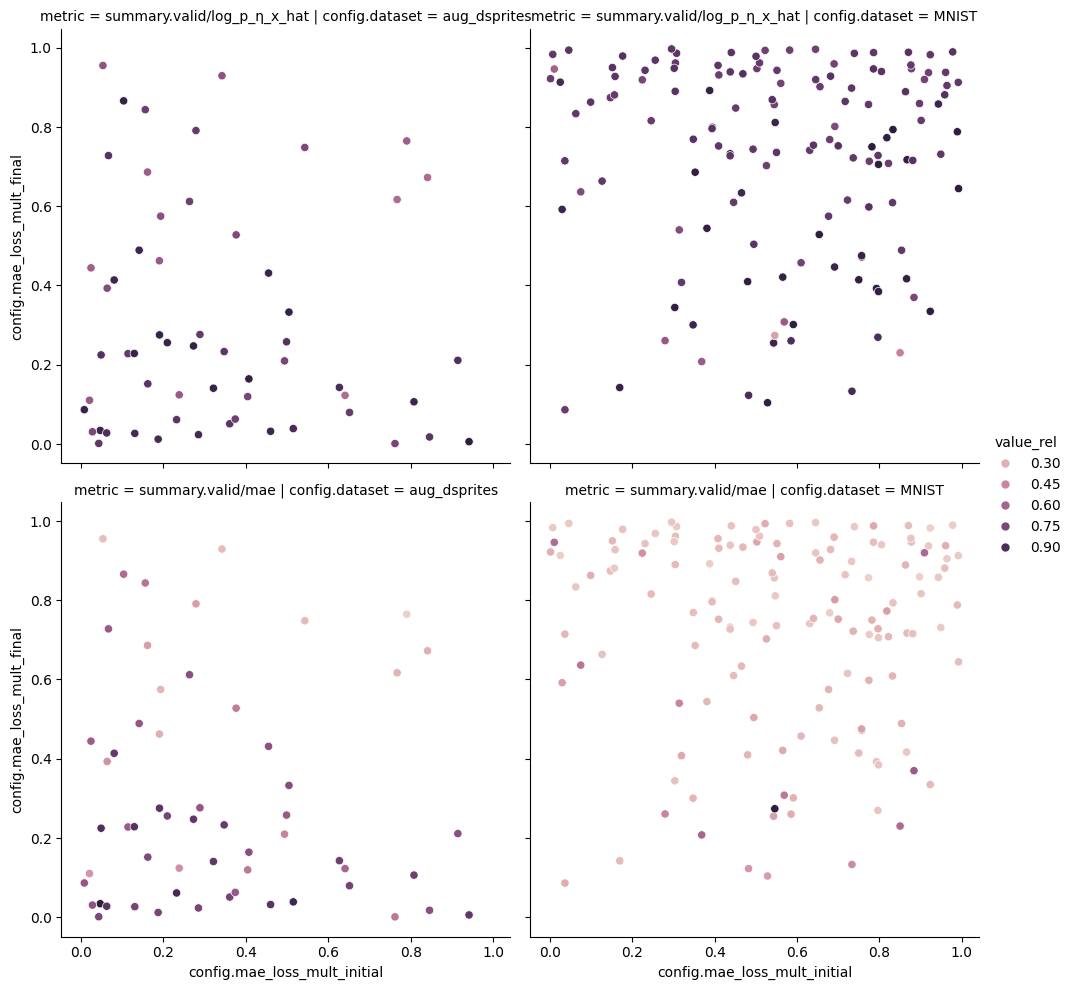

In [32]:
# create a new column that is the value, divided by the maximum when grouped by dataset
df_tmp = df[(df.metric.isin(['summary.valid/mae', METRIC])) & (df['config.n_samples'] != '1')]
df_tmp['value_rel'] = df_tmp['value'] / df_tmp.groupby(['config.dataset', 'metric'])['value'].transform('max')

g = sns.relplot(
    df_tmp,
    x="config.mae_loss_mult_initial",
    y="config.mae_loss_mult_final",
    col='config.dataset',
    row='metric',
    hue="value_rel",
    # palette='viridis',
    # aspect=2.,
)
# g.map_upper(sns.stripplot, s=7, marker="D", alpha=.5,)
# g.map_lower(sns.stripplot, dodge=True, s=7, marker="D", alpha=.5,)
# g.add_legend()

g

### model.conditioner.dropout_rate

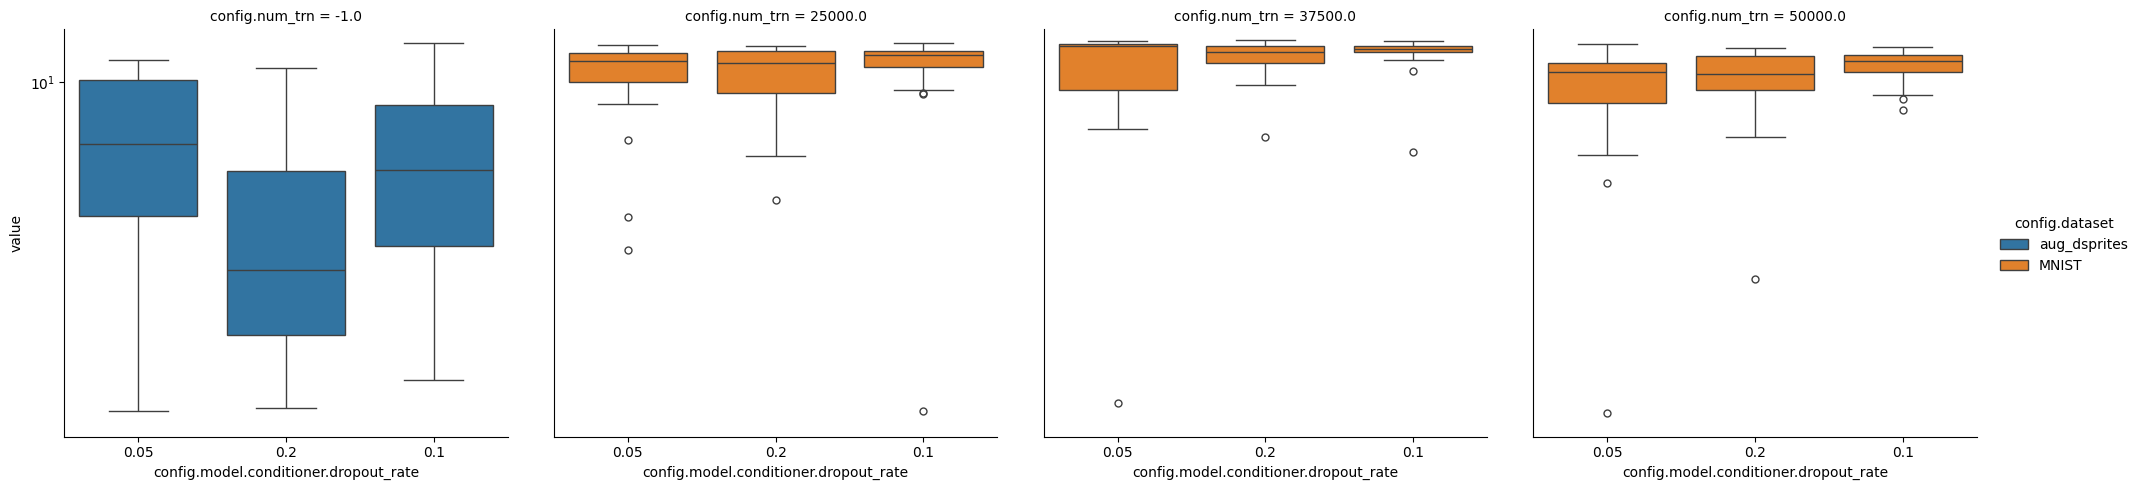

In [33]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.dropout_rate",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

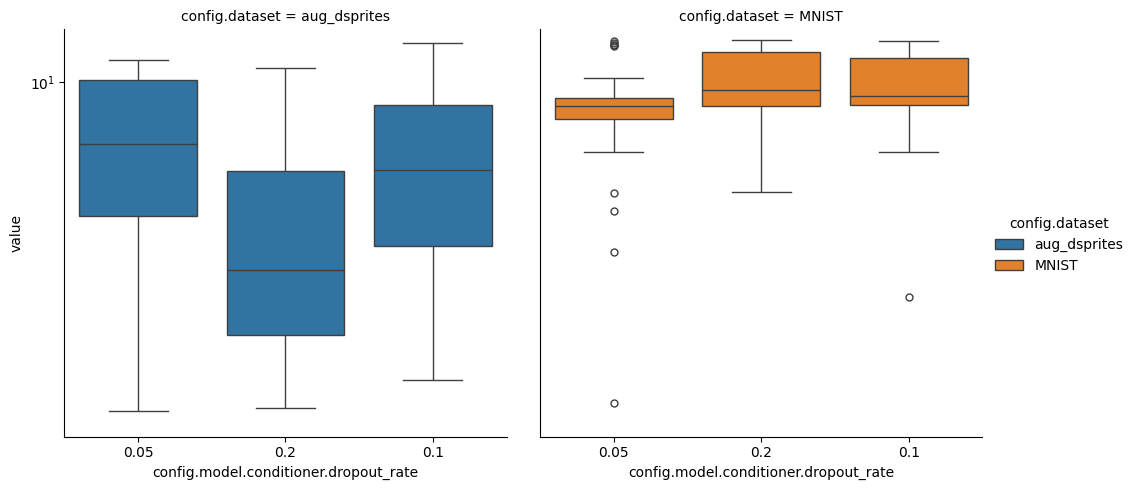

In [34]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.dropout_rate",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.conditioner.hidden_dims

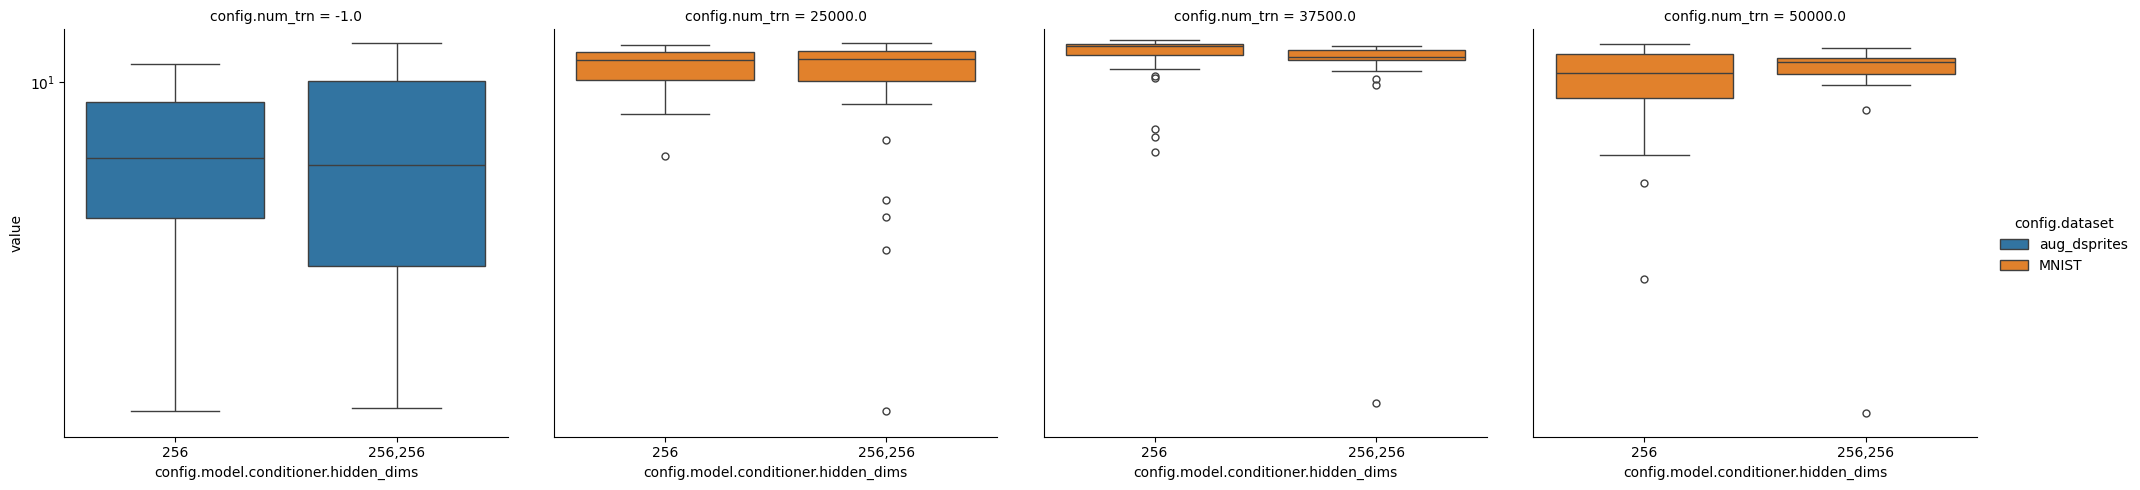

In [35]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.hidden_dims",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

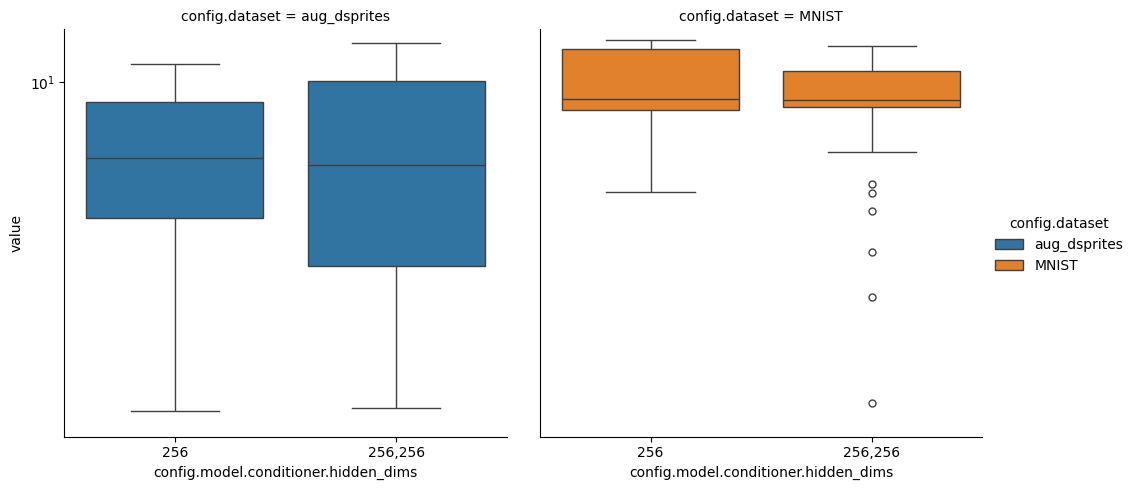

In [36]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.conditioner.hidden_dims",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.dropout_rate

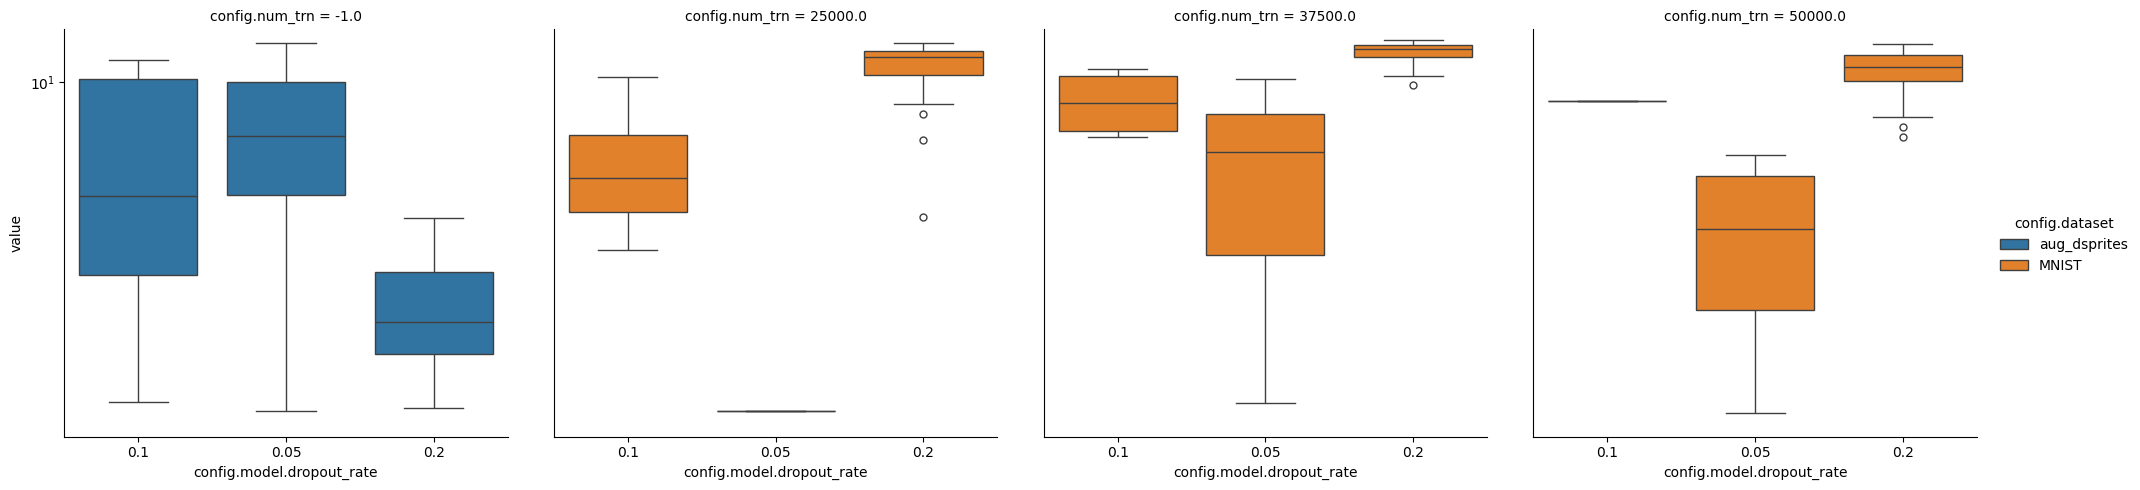

In [37]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.dropout_rate",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

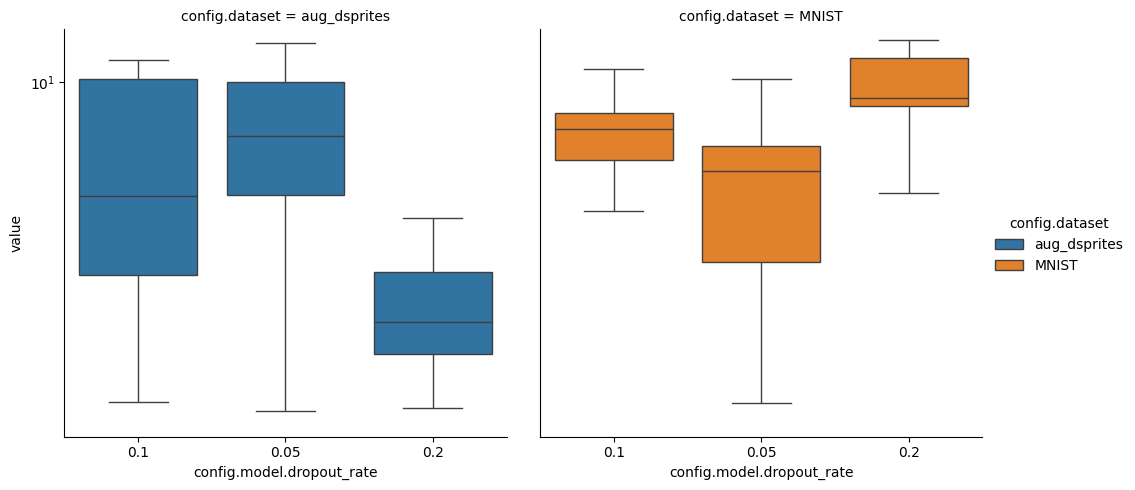

In [38]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.dropout_rate",
    y="value",
    col="config.dataset", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.num_bins

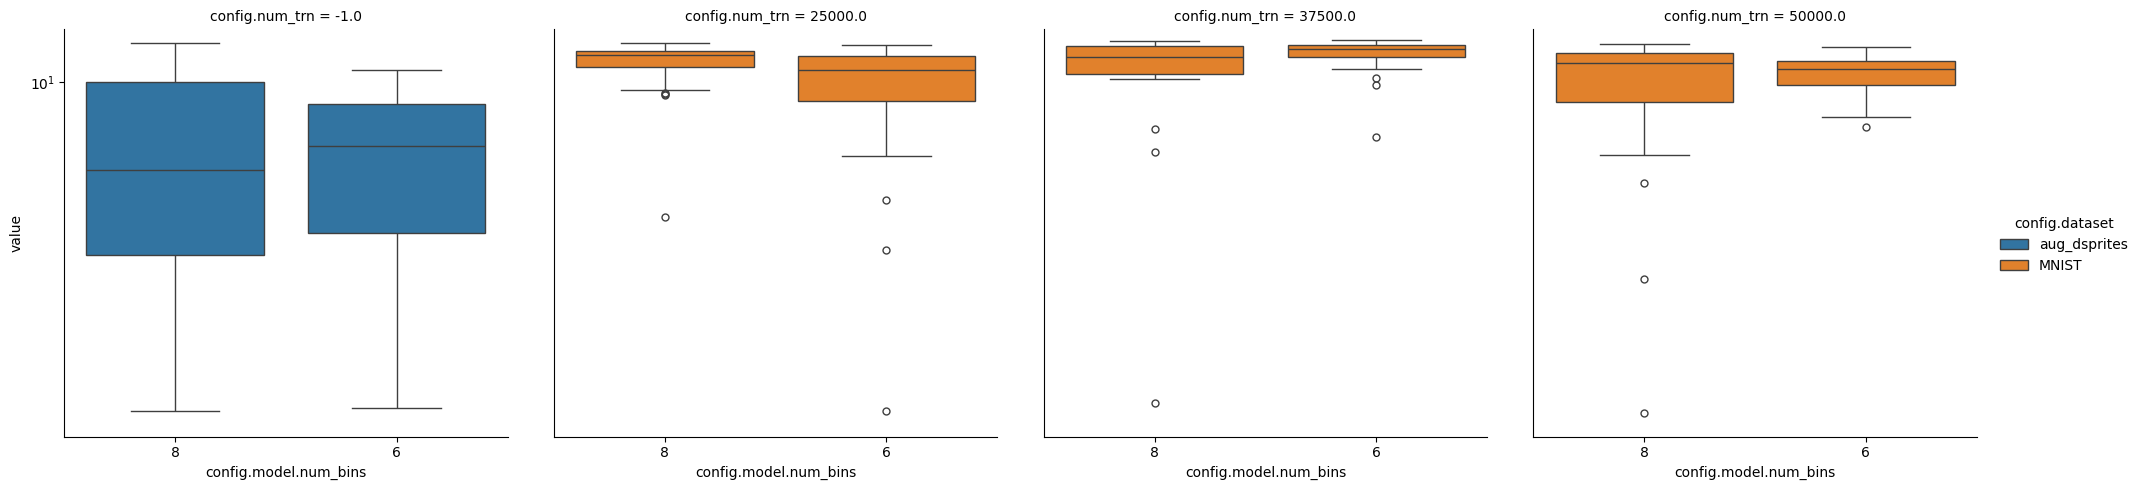

In [39]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_bins",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

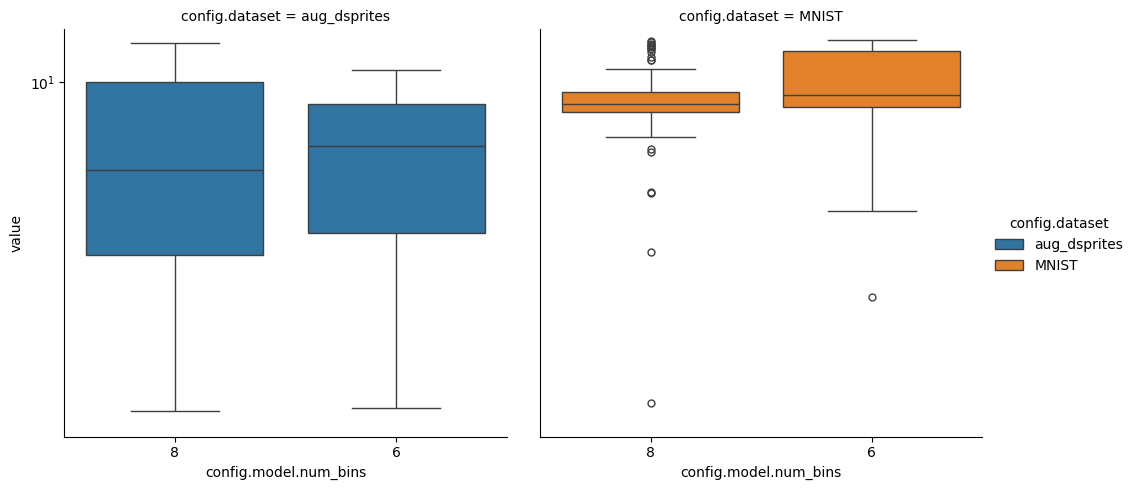

In [40]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_bins",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### model.num_flows

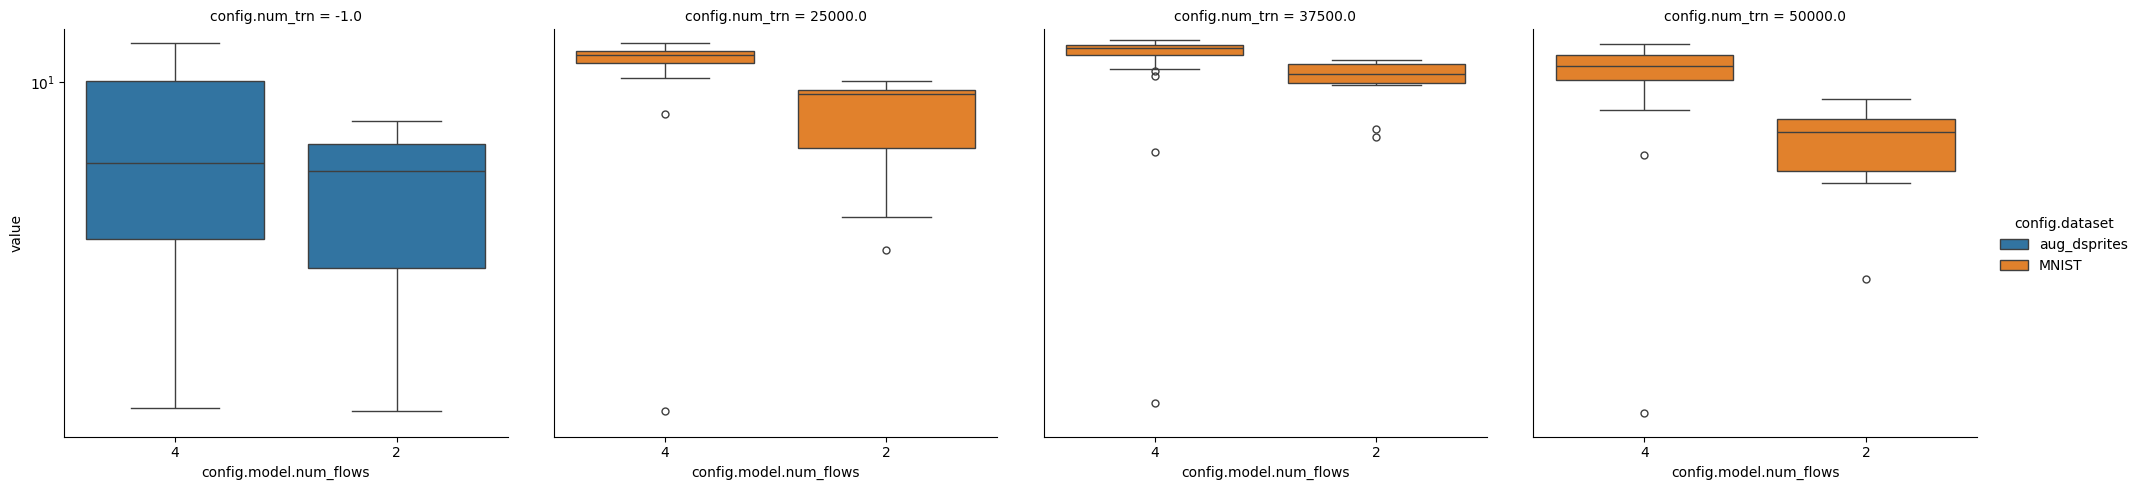

In [41]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_flows",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

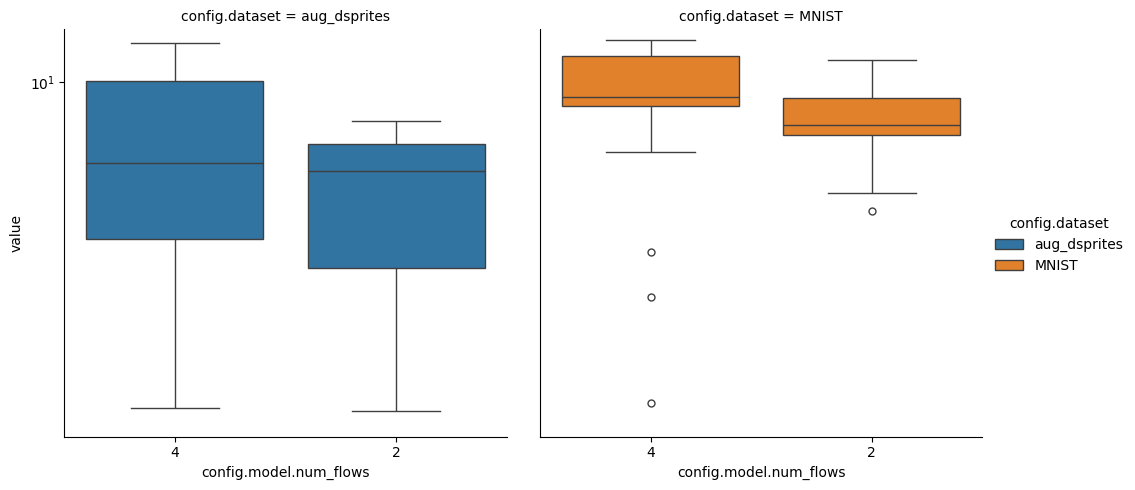

In [42]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.num_flows",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### n_samples

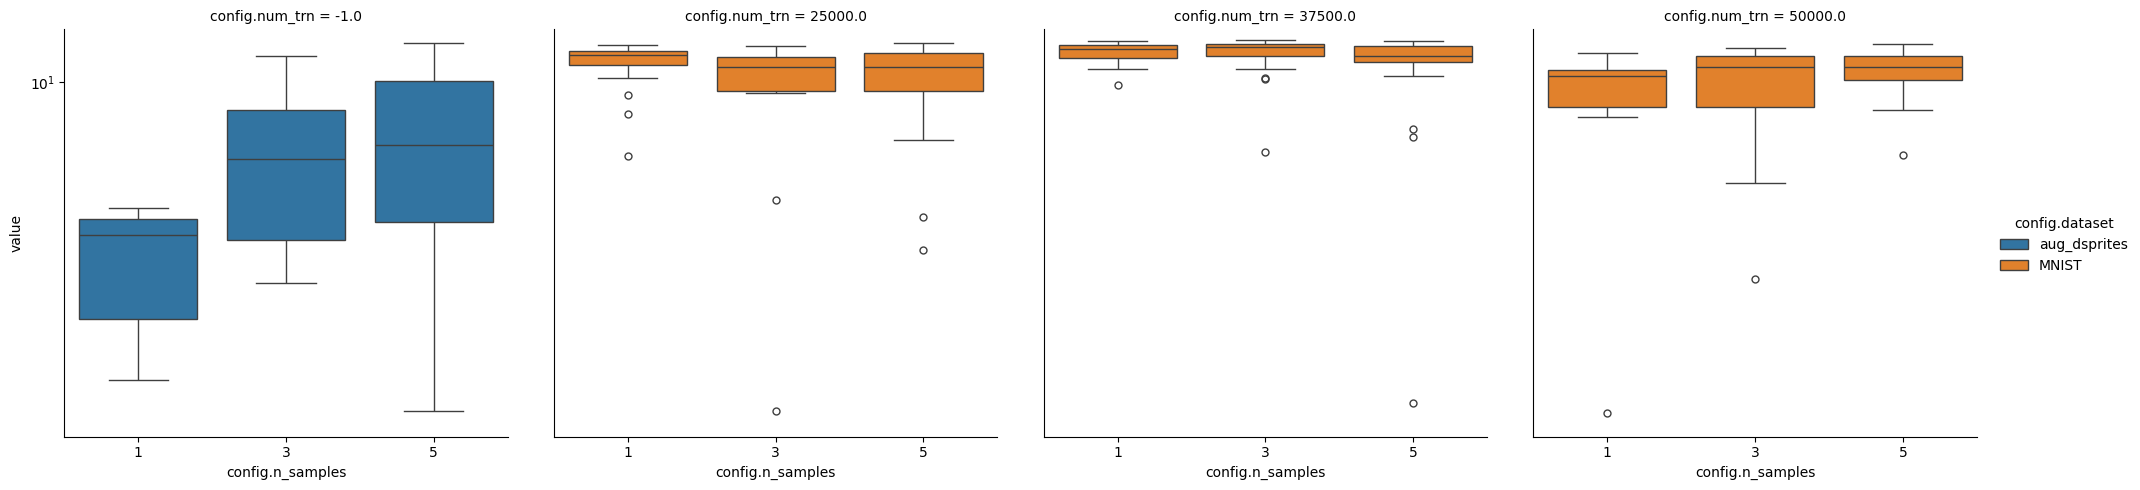

In [43]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.n_samples",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

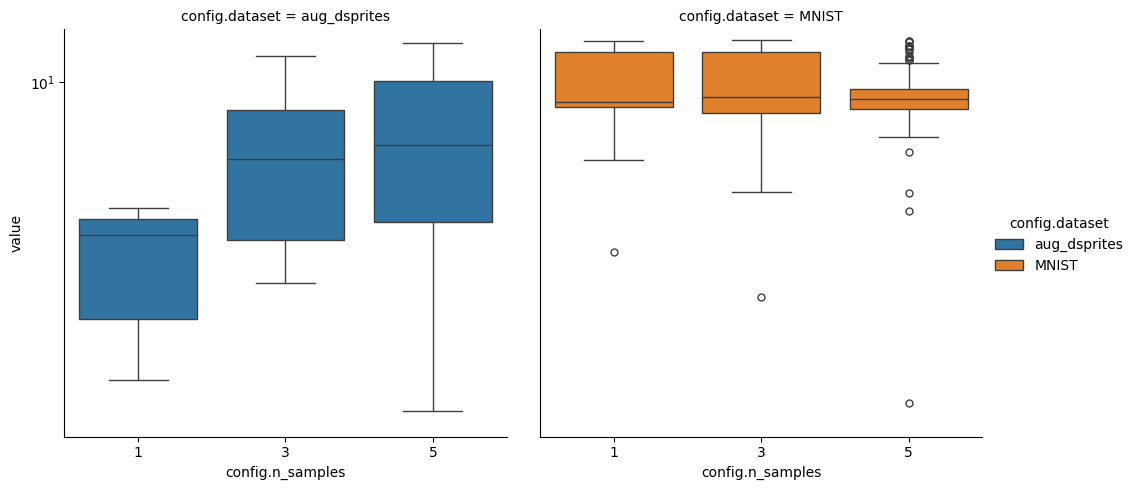

In [44]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.n_samples",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### steps

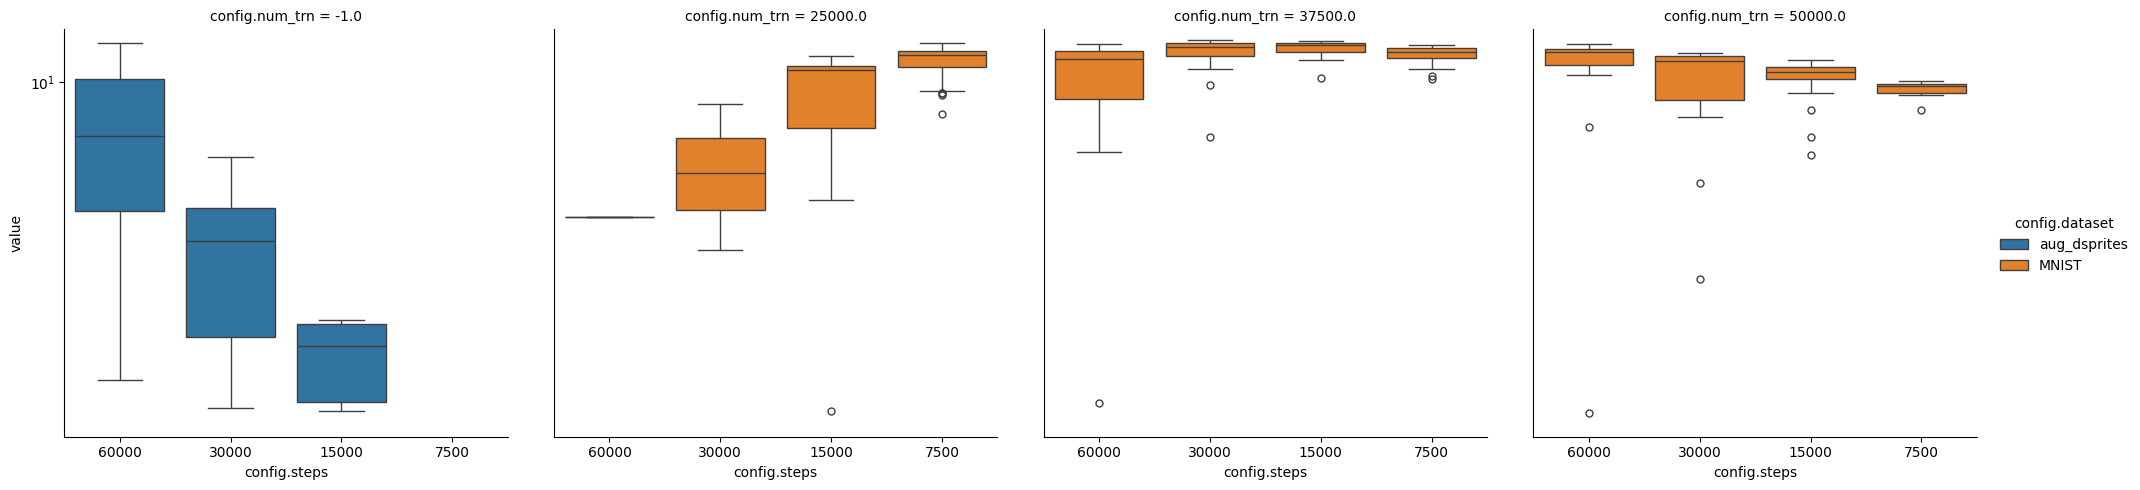

In [45]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.steps",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

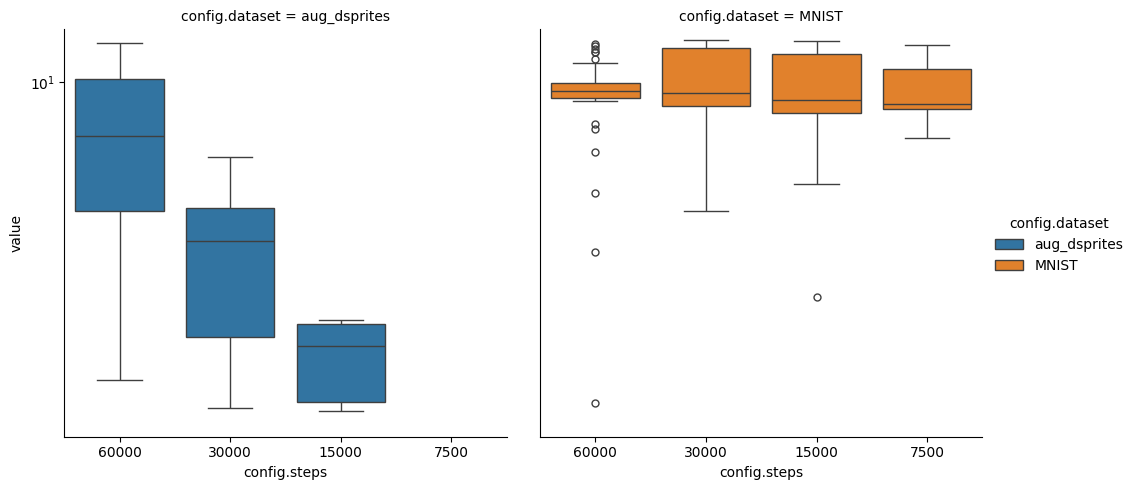

In [46]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.steps",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="symlog")

g

### warmup_steps_pct

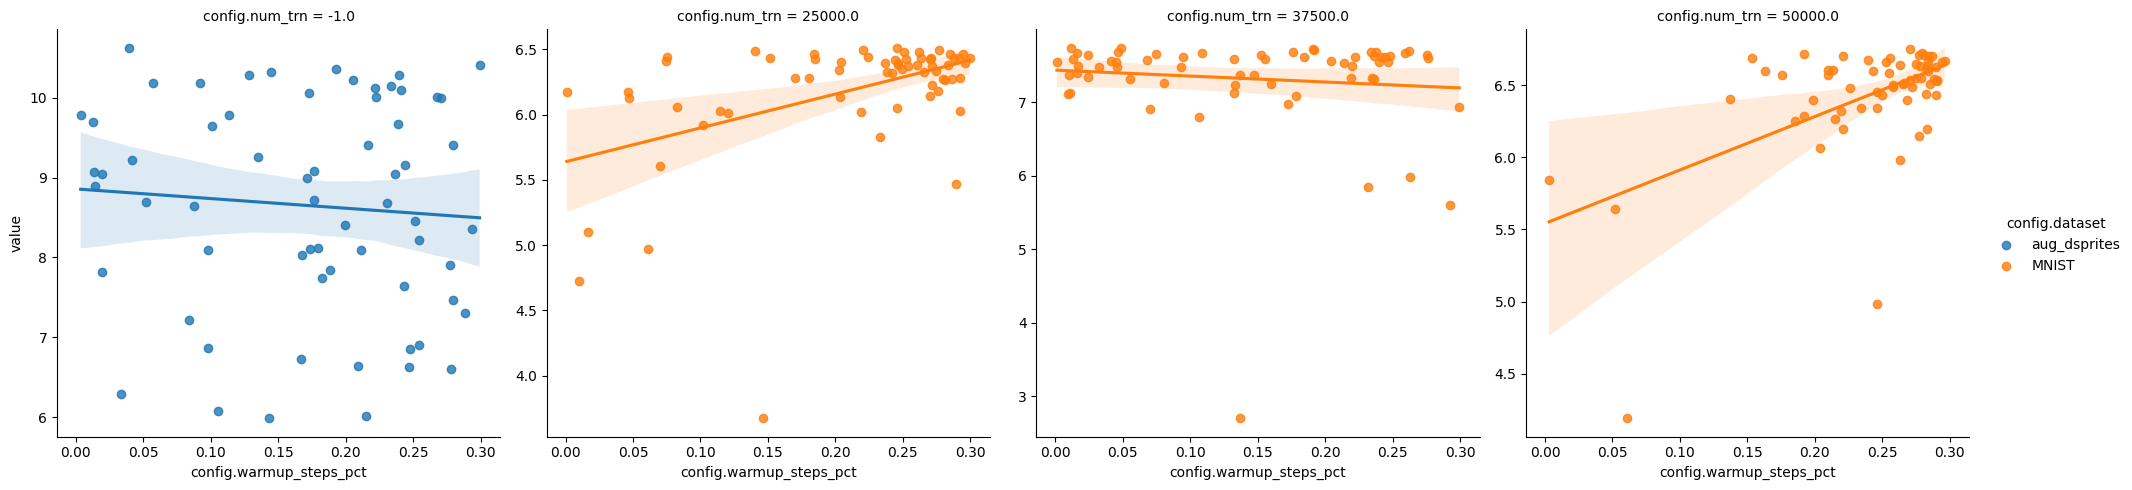

In [47]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.warmup_steps_pct",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

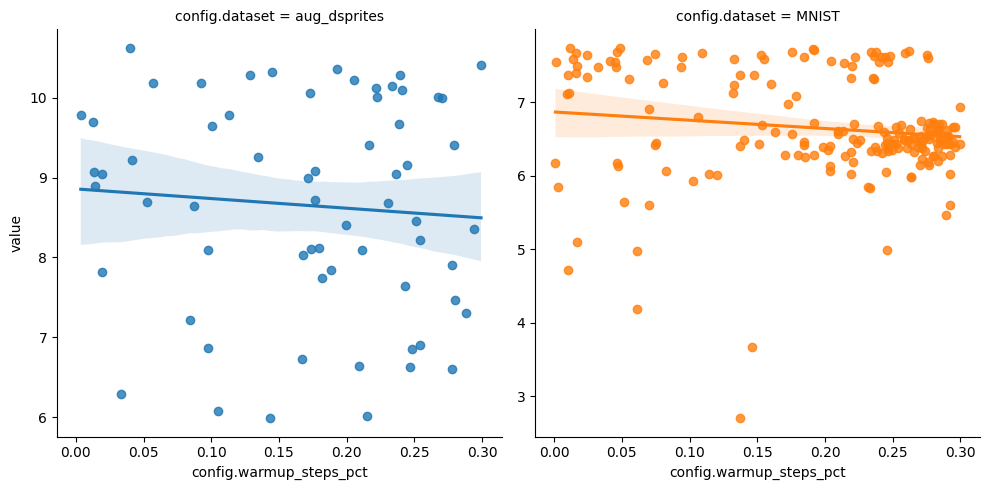

In [48]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.warmup_steps_pct",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

# g.set(xscale="log")

g

### weight_decay

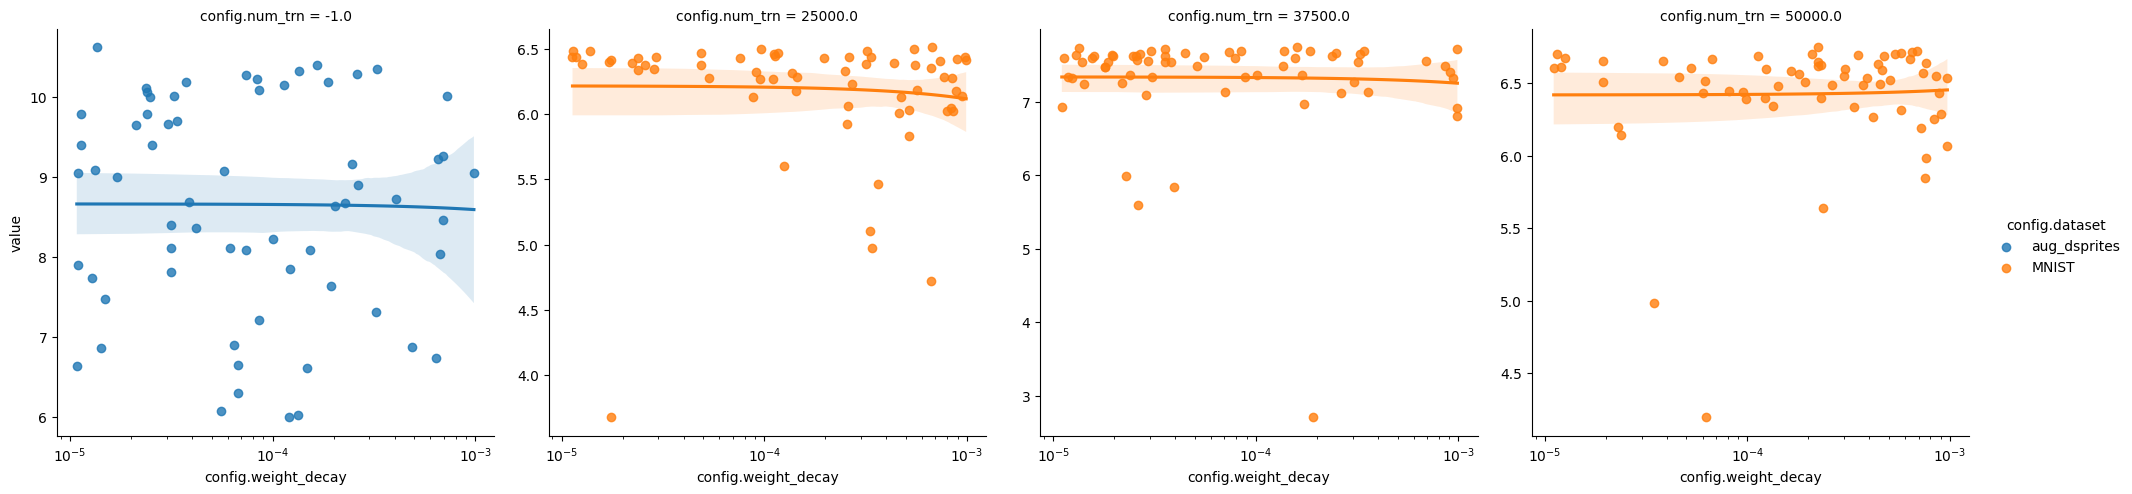

In [49]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.weight_decay",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g

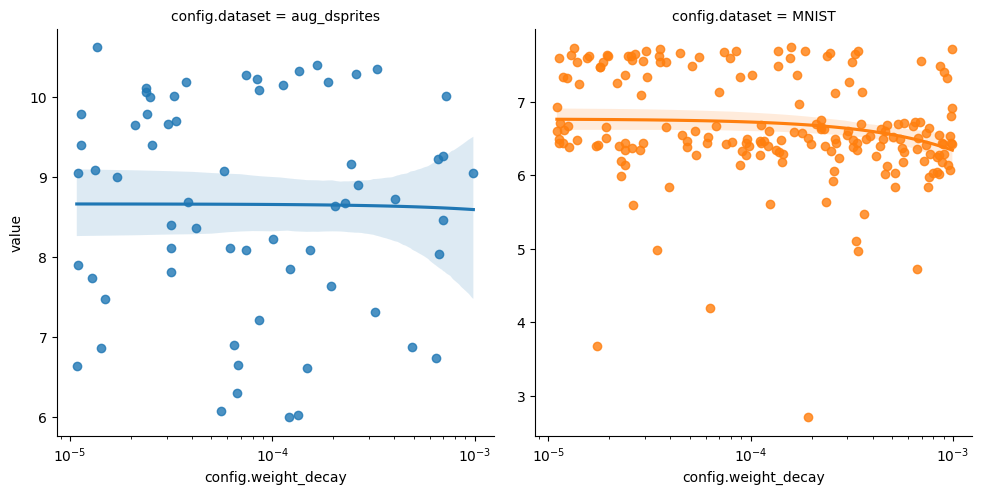

In [50]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.weight_decay",
    y="value",
    hue='config.dataset',
    col="config.dataset",
    facet_kws={'sharex': True, 'sharey': False},
    order=1
)

g.set(xscale="log")

g